<a href="https://colab.research.google.com/github/JuanParias29/ML_Stroke_Classification_model/blob/main/Arias_PySpark_Taller_Metricas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

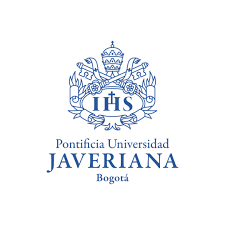
***Pontificia Universidad Javeriana***
# **Procesamiento de Alto Volumen de Datos**

### Taller: **Métricas de Rendimiento para Modelos de Clasificación con PySpark**

Autor: Juan Pablo Arias Buitrago
Fecha: 19/05/2025

**Objetivo**: Evaluar modelo de clasificación MLlib

- La clasificación se utiliza para clasificar datos en etiquetas o clases predefinidas. Para evaluar el rendimiento de un modelo de clasificación se suelen utilizar métricas como: accuracy, precision, recall, F1 score y la matriz de confusión. Estas métricas son útiles para evaluar lo bien que el modelo distingue entre clases, especialmente en casos de conjuntos de datos desequilibrados. Al conocer los puntos fuertes y débiles de cada métrica, se podrá seleccionar la más adecuada para un problema de clasificación determinado.

- MLlib de PySpark, se presenta un conjunto de clases: BinaryClassificationEvaluator, MulticlassificationEvaluator, y RegressionEvaluator-diseñadas para evaluar el rendimiento de los modelos de aprendizaje automático calculando métricas específicas a partir de predicciones y etiquetas verdaderas. Se utilizan para evaluar modelos entrenados con estimadores como RandomForestClassifier o GBTRegressor, tomando un DataFrame con valores predichos y reales para producir una única puntuación de rendimiento. Ejecutados a través de una SparkSession, aprovechan los ejecutores de Spark para la computación distribuida, lo que los hace ideales para **BIG DATA** de fuentes como archivos CSV o Parquet. Se integran en herramientas de ajuste como CrossValidator y TrainValidationSplit, ofreciendo una solución escalable para la evaluación de modelos.
____________________________________________________

**1.- Crear sessión PySpark**

In [1]:
from pyspark.sql.functions import col, when, avg
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("Taller_Metricas").getOrCreate()

cores = spark._jsc.sc().getExecutorMemoryStatus().keySet().size()
print("Ejcución de las tareas en ", cores, "core(s) del sistema de cómputo actual")
spark

Ejcución de las tareas en  1 core(s) del sistema de cómputo actual


**2.-Cargar DataFrame Spark**

In [2]:
from pyspark import SparkFiles
url_github = "https://raw.githubusercontent.com/corredor-john/ExploratoryDataAnalisys/refs/heads/main/Varios/heart_taller_eval_PySpark.csv"

spark.sparkContext.addFile(url_github)
df00 = spark.read.csv(SparkFiles.get("heart_taller_eval_PySpark.csv"),inferSchema=True, header=True)
df00.show(5)

+---+---+-------------+---------+-----------+---------+----------+-----+--------------+-------+--------+------------+
|Age|Sex|ChestPainType|RestingBP|Cholesterol|FastingBS|RestingECG|MaxHR|ExerciseAngina|Oldpeak|ST_Slope|HeartDisease|
+---+---+-------------+---------+-----------+---------+----------+-----+--------------+-------+--------+------------+
| 40|  M|          ATA|      140|        289|        0|    Normal|  172|             N|    0.0|      Up|           0|
| 49|  F|          NAP|      160|        180|        0|    Normal|  156|             N|    1.0|    Flat|           1|
| 37|  M|          ATA|      130|        283|        0|        ST|   98|             N|    0.0|      Up|           0|
| 48|  F|          ASY|      138|        214|        0|    Normal|  108|             Y|    1.5|    Flat|           1|
| 54|  M|          NAP|      150|        195|        0|    Normal|  122|             N|    0.0|      Up|           0|
+---+---+-------------+---------+-----------+---------+-

**3.- Revisión de Datos Nulos o Imposibles:**

In [3]:
from pyspark.sql.functions import *

df00.select([count(when(col(c).contains('None') |
col(c).contains('NULL') |
(col(c) == '' ) |
col(c).isNull() | isnan(c), c )).alias(c)
for c in df00.columns]).show()

+---+---+-------------+---------+-----------+---------+----------+-----+--------------+-------+--------+------------+
|Age|Sex|ChestPainType|RestingBP|Cholesterol|FastingBS|RestingECG|MaxHR|ExerciseAngina|Oldpeak|ST_Slope|HeartDisease|
+---+---+-------------+---------+-----------+---------+----------+-----+--------------+-------+--------+------------+
|  0|  0|            0|        0|          0|        0|         0|    0|             0|      0|       0|           0|
+---+---+-------------+---------+-----------+---------+----------+-----+--------------+-------+--------+------------+



**4.- Relación entre las variables**
- Existe una correlacion positiva fuerte entre el resultado negativo del eletrocardiagrama y la posibilidad de sufrír una enfermedad cardiaca (cardiopatía).
  - Este valor es de **-0,4**
- La correlación inversa (negativa) entre la edad y la frecuecia cardiaca maxima, pues a medida que aumenta la edad, se reduce las ppm máximas.
  - Este valor es de **-0,38**
- La correlación inversa (negativa) entre la cadiopatía y la frecuecia cardiaca maxima, pues a medida que se reducen las ppm máximas, aumenta el riesgo de sufrír una cardiopatía.
  - Este valor es de **-0,4**
- Existe cierta correlción entre la cadiopatía y el colesterol, ya que se asocia un mayor indice de riesgo de cardiopatía con altos niveles de colesterol.
  - Este valor es de **-0,23**


Si bien no exiten fuertes correlaciones indivuduales entre todos los parametros y el objetivo de predicción (cardiopatía) es importante tener en cuenta que la suma de estos parametros es crucial para determinar si un paciente sufre o no una enfermedad cardiaca. Pues por si solo un sintoma (colesterol) no indica nada, pero la suma de sintomas es lo que mejora la precision con la cual se diagnositca a tiempo distintas enfermedades.

<Axes: >

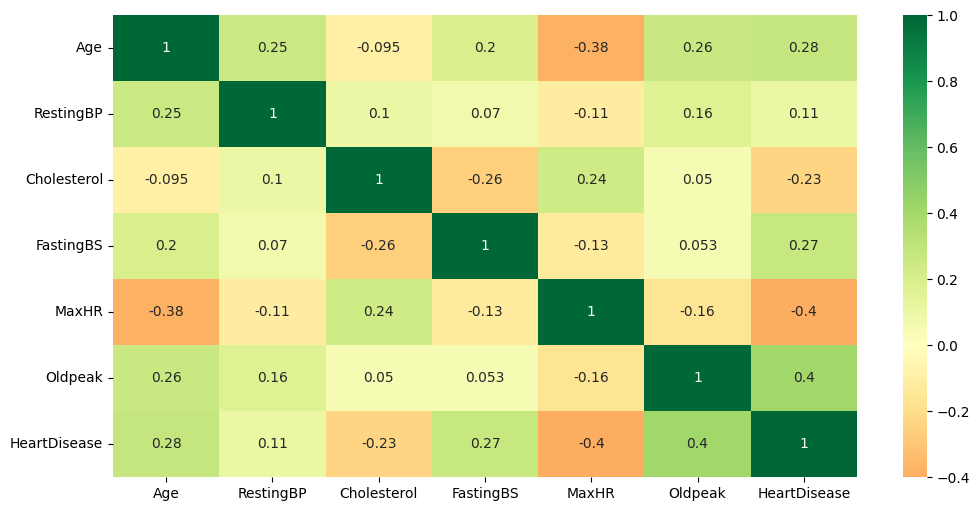

In [4]:
import matplotlib.pyplot as ptl
import seaborn as sns

vista_pandas = df00.toPandas()
ptl.figure(figsize=(12, 6))
sns.heatmap(vista_pandas.select_dtypes(np.number).corr(), annot=True, center=0, cmap ='RdYlGn')

### Ingeniería de características

**5.- Consulte los tipos de datos**

In [5]:
df00.dtypes

[('Age', 'int'),
 ('Sex', 'string'),
 ('ChestPainType', 'string'),
 ('RestingBP', 'int'),
 ('Cholesterol', 'int'),
 ('FastingBS', 'int'),
 ('RestingECG', 'string'),
 ('MaxHR', 'int'),
 ('ExerciseAngina', 'string'),
 ('Oldpeak', 'double'),
 ('ST_Slope', 'string'),
 ('HeartDisease', 'int')]

**6.- Funciones para datos ETIQUETAS o categorías a Numéricos**
- 6.1: Imprimir todas las columnas de Etiquetas del tipo string


In [6]:
#Imprimir todas las columnas de Etiquetas del tipo string
dataframe = df00
dataframe.select('Sex').distinct().show()
dataframe.select('ChestPainType').distinct().show()
dataframe.select('RestingECG').distinct().show()
dataframe.select('ExerciseAngina').distinct().show()
dataframe.select('ST_Slope').distinct().show()

+---+
|Sex|
+---+
|  F|
|  M|
+---+

+-------------+
|ChestPainType|
+-------------+
|          NAP|
|          ATA|
|           TA|
|          ASY|
+-------------+

+----------+
|RestingECG|
+----------+
|       LVH|
|    Normal|
|        ST|
+----------+

+--------------+
|ExerciseAngina|
+--------------+
|             Y|
|             N|
+--------------+

+--------+
|ST_Slope|
+--------+
|    Flat|
|      Up|
|    Down|
+--------+



- 6.2: Usar la función para cambiar a dato numéricos


In [7]:
from pyspark.sql.types import *
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import when, col

def fun_Etiquetas(df):
    trans_df = df.select("*",
                 (when(df.ExerciseAngina=='Y', 1).otherwise(0)).alias('yes_exercise_angina'),
                 (when(df.ChestPainType=='ATA', 1).otherwise(0)).alias('ata_chest_pain_type'),
                 (when(df.ChestPainType=='ASY', 1).otherwise(0)).alias('asy_chest_pain_type'),
                 (when(df.ST_Slope=='Up', 1).otherwise(0)).alias('up_st_slope'),
                 (when(df.Sex=='F', 1).otherwise(0)).alias('f_sex'),
                 (when(df.RestingECG=='ST', 1).otherwise(0)).alias('st_resting_ecg')
                 )\
        .drop('ExerciseAngina','ChestPainType', 'ST_Slope', 'Sex', 'RestingECG')\
        .withColumnRenamed("HeartDisease", 'label')

    features_list = trans_df.columns
    print(features_list)
    features_list.remove('label')
    assembler = VectorAssembler(inputCols=features_list,outputCol='features')
    vector_trans_df = assembler.transform(trans_df).select('features','label')

    return vector_trans_df, trans_df


vector_trans_df, trans_df = fun_Etiquetas(dataframe)

['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak', 'label', 'yes_exercise_angina', 'ata_chest_pain_type', 'asy_chest_pain_type', 'up_st_slope', 'f_sex', 'st_resting_ecg']


6.3.- Imprimir 5 primeros valores de la transformación a vectores

In [8]:
vector_trans_df.show(5,False)

+--------------------------------------------------------+-----+
|features                                                |label|
+--------------------------------------------------------+-----+
|(12,[0,1,2,4,7,9],[40.0,140.0,289.0,172.0,1.0,1.0])     |0    |
|(12,[0,1,2,4,5,10],[49.0,160.0,180.0,156.0,1.0,1.0])    |1    |
|[37.0,130.0,283.0,0.0,98.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0] |0    |
|[48.0,138.0,214.0,0.0,108.0,1.5,1.0,0.0,1.0,0.0,1.0,0.0]|1    |
|(12,[0,1,2,4,9],[54.0,150.0,195.0,122.0,1.0])           |0    |
+--------------------------------------------------------+-----+
only showing top 5 rows



**7.- División de Datos Entrenamiento y Prueba**

In [9]:
entrenamiento, prueba = vector_trans_df.randomSplit([0.7,0.3], seed = 13)

**8.- Balanceo de Cargas**

Como se puede obvservar en el gráfico y la métrica obtenido del porcentaje de registros con casos positivos (54%) se puede concluir que el conjunto de datos esta balanceado para que el modelo de predicción pueda indetificar mejor cada una de las clases, de esta manera se reducen lso sesgos del modelo al predecir si un paciente padece o no una cardiopatía

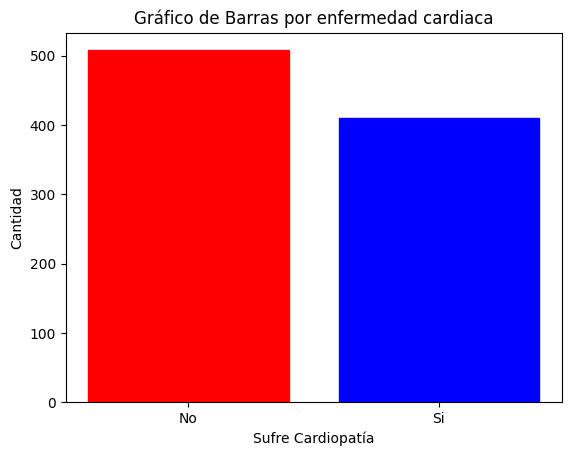

In [10]:
#Gráfica del balanceo de datos
import matplotlib.pyplot as plt

enfCardiaca = dataframe.groupBy('HeartDisease').count().select('HeartDisease', 'count')
enfCardiaca_filtered = enfCardiaca.filter((col('HeartDisease') == 0) | (col('HeartDisease') == 1))
enfCardiaca_filtered = enfCardiaca_filtered.rdd.map(lambda x: (x[0], x[1])).collect()

categorias = ['No', 'Si']
cantidad = [x[1] for x in enfCardiaca_filtered]
grafica = plt.bar(categorias, cantidad)

grafica[0].set_color('r')
grafica[1].set_color('b')

plt.ylabel('Cantidad')
plt.xlabel('Sufre Cardiopatía')
plt.title('Gráfico de Barras por enfermedad cardiaca')
plt.show()

In [11]:
total=float(entrenamiento.select("label").count())
Positivos=entrenamiento.select("label").where('label == 1').count()
porcentaje=(float(Positivos)/float(total))*100
Negativos=float(total-Positivos)
print('Cantidad de positivos {}'.format(Positivos))
print('Porcentaje de positivos {}'.format(porcentaje))

Cantidad de positivos 359
Porcentaje de positivos 53.9039039039039


## Modelado

**9.- Modelo a seguir es de árboles de decisiones**



In [12]:
from pyspark.ml.classification import DecisionTreeClassifier

parametros = {'maxDepth':4}

clasificador = DecisionTreeClassifier(**parametros, seed= 13)
clasificador

modeloArboles = clasificador.fit(entrenamiento)

**10.- Predicciones sobre los datos de prueba**

In [13]:
prediccionesPrueba = modeloArboles.transform(prueba)
prediccionesPrueba.show(2, False)

+---------------------------------------------------+-----+-------------+---------------------------------------+----------+
|features                                           |label|rawPrediction|probability                            |prediction|
+---------------------------------------------------+-----+-------------+---------------------------------------+----------+
|(12,[0,1,2,3,4],[74.0,140.0,237.0,1.0,94.0])       |1    |[9.0,36.0]   |[0.2,0.8]                              |1.0       |
|(12,[0,1,2,3,4,5],[52.0,152.0,298.0,1.0,178.0,1.2])|0    |[6.0,15.0]   |[0.2857142857142857,0.7142857142857143]|1.0       |
+---------------------------------------------------+-----+-------------+---------------------------------------+----------+
only showing top 2 rows



##**11.- Evaluación de Modelo de Clasificación**

- Presente la matriz de confusión y de sus apreciaciones
- Reto pinte ROC y obtenga el valor AUC y de sus apreciaciones


In [14]:
matrzC_prueba = prediccionesPrueba.crosstab("prediction", "label")
matrzC_prueba = matrzC_prueba.toPandas()
matrzC_prueba.sort_values(by = ['prediction_label'])

,prediction_label,0,1
1,0.0,82,27
0,1.0,21,122


In [15]:
TP = matrzC_prueba["1"][0]
FP = matrzC_prueba["0"][0]
TN = matrzC_prueba["0"][1]
FN = matrzC_prueba["1"][1]
Accuracy = (TP+TN)/(TP+FP+TN+FN)
Sensitivity = TP/(TP+FN)
Specificity = TN/(TN+FP)
Precision = TP/(TP+FP)

print(f"Accuracy = {np.round(Accuracy,2)*100}%")
print(f"Precision = {np.round(Precision,2)*100}%")
print(f"Sensitivity = {np.round(Sensitivity,2)*100}%")
print(f"Specificity = {np.round(Specificity,2)*100}%")

Accuracy = 81.0%
Precision = 85.0%
Sensitivity = 82.0%
Specificity = 80.0%


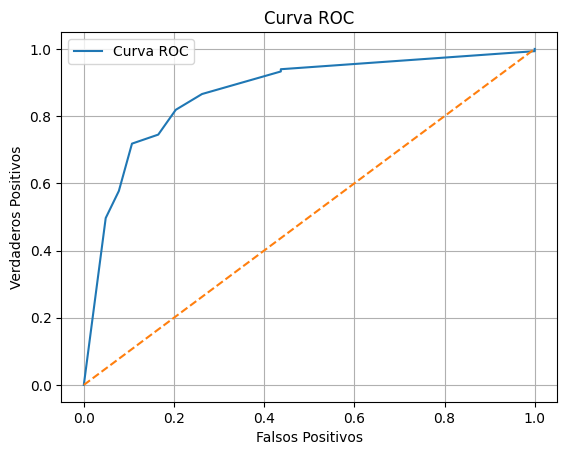

AUC-ROC = 87.0%


In [16]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
import numpy as np

resultados = prediccionesPrueba.select("label", "probability").toPandas()
probabilidades = resultados['probability'].apply(lambda x: x[1])
fpr, tpr, thresholds = roc_curve(resultados['label'], probabilidades)

plt.plot(fpr, tpr, label="Curva ROC")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('Falsos Positivos')
plt.ylabel('Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend()
plt.grid()
plt.show()

evaluator = BinaryClassificationEvaluator(rawPredictionCol="probability", labelCol="label", metricName="areaUnderROC")
auc_roc_value = evaluator.evaluate(prediccionesPrueba)

print(f"AUC-ROC = {np.round(auc_roc_value, 2) * 100}%")

# **Métricas**
**1. Accuracy (Exactitud)**  
* Es el porcentaje de pacientes que el modelo clasificó correctamente, ya sea que tenían o no una enfermedad cardíaca. Aunque es una métrica intuitiva y global, **no basta por sí sola** para evaluar la eficacia del modelo en un contexto clínico.

* El resultado obtenido indica que el modelo tiene una **buena capacidad de clasificación global**, con una exactitud del **81.0%**, lo cual sugiere un buen desempeño general, aunque debe complementarse con otras métricas más clínicas.

**2. Precision (Precisión)**  
* Es el porcentaje de pacientes alertados por el modelo como enfermos del corazón que efectivamente **tenían enfermedad cardíaca**. Una alta precisión implica que el modelo lanza pocas falsas alarmas (falsos positivos).

* Para este problema, esto es valioso porque evita **alarmar a pacientes sanos**, sometiéndolos a **exámenes costosos e invasivos innecesarios**, o generando ansiedad sin motivo justificado.

* El resultado obtenido indica que el modelo es bastante confiable para identificar correctamente a los pacientes con enfermedad cardíaca sin sobrediagnosticar, con una precisión del **85.0%**.

**3. Recall (Sensibilidad o Tasa de verdaderos positivos)**  
* Es el porcentaje de pacientes que realmente tenían enfermedad cardíaca y que el modelo detectó correctamente.

* Es la métrica más relevante en este problema, ya que es más crítico que un paciente sufra una enfermedad cardíaca y **no detectarlo a tiempo**, que alertar falsamente a uno sano.

* El resultado obtenido indica que el modelo tiene una buena sensibilidad en los pacientes con enfermedad cardíaca con un Recall del **82.0%**.

**4. F1 Score**  
* Es un punto medio entre precisión y recall, balanceando ambas métricas. Para este problema, considera tanto la capacidad del modelo para **detectar correctamente los casos reales** como para **evitar falsas alarmas**.

* El resultado obtenido indica que el modelo hace un buen equilibrio entre no perder casos reales y no alertar falsamente en un **83.5%** aproximadamente.

**5. AUC_ROC**  
* La curva ROC muestra cómo varía la **tasa de verdaderos positivos (sensibilidad)** frente a la **tasa de falsos positivos (1 - especificidad)** a distintos umbrales de decisión.

* En este contexto, representa la capacidad del modelo para distinguir entre un paciente con enfermedad cardíaca y uno sano.

* El resultado obtenido indica que el modelo tiene un **87%** de probabilidad de asignar un mayor puntaje de riesgo a un paciente con enfermedad cardíaca que a uno sano.  
Esto refleja un **alto poder de discriminación**, mostrando que el modelo logra un excelente equilibrio entre **detectar a los pacientes enfermos** y **minimizar falsas alarmas**.


**12.- Terminar sesión SPARK**

In [17]:
spark.stop()

## **12.- Conclusiones: redacte sus conclusiones por cada paso y conclusión final de Cierre**

**Configuración del entorno**
  * Se inicializó una sesión de PySpark con SparkSession y se confirmo la ejecución con los cores.

**Carga del Dataset**
  * Se cargó un CSV desde GitHub

**Verificación de Datos Nulos**
  * Se revisó columna por columna si hay valores nulos. Sin embargo, no se encontró ninguno. Lo cual indica una alta calidad en el conjunto de datos

**Análisis Exploratorio - Correlaciones**
  * Se observó la relación entre variables numéricas mediante un mapa de calor.
  * Se describieron algunas correlaciones relevantes.

**Ingeniería de Características**
  * Se identificaron columnas categóricas.
  * Se aplicaron transformaciones manuales

**División del conjunto de datos**
  * Se separaron los datos en entrenamiento y prueba (70% - 30%).

**Verificación de balanceo**
  * Se graficó y calculó el porcentaje de casos positivos: 54%.
  * **Conclusión:** el dataset está bastante balanceado para entrenar un modelo.

**Entrenamiento y predicciones del Modelo**
  * Se utilizó un modelo de clasificación de Árboles de Decisión
  * Se predijeron las etiquetas para los datos de prueba.

**Evaluación del Modelo (Métricas)**
  * Se utilizó la matriz de confusión para hacer un analisis inicial del modelo y el significado de cada valor en el contexto de la prediccion de enfermedad cardiaca.
  * Se evaluo apartir de las métricas (Acurracy, Precision, Recall y f1-score) que tan bueno es el modelo. concluyendo que el modelo es eficiente al momento de predecir correctamente si un paciente padece una enfermadad cardiaca(cardipatía).
  * Tambien se evaluo la eficiencia del modelo para distingir entre ambas clases usando la métrica AUC_ROC, concluyendo que el modelo tiene bajo indice de falsas alarmas, es decir, mantiene un buen grado de dicernimiento de probabilidad.